![avatar](../St_Gallen.png)


# Replication Project: A quantitative theory of the gender gap in wages (Erosa, Fuster & Restuccia 2016)

### Alfred Sutter,  Marco Mueller,  Xianyu Tang,  Ao Sun,  Xiaoqian Zhu 
Solving the dynamic model of the paper is a high dimensional problem that requires a lot of computational power. However, many aspects of this paper can be parallelized. Consequently, we can shorten the running time of the code significantly by using parallel computing packages. As recommended by Fernández-Villaverde & Zarruk (2018) we use the packages "Distributed" and "SharedArrays".
In a first step, we load the packages and define the number of workers used in parallel computing. If you have less then four CPU cores available, please adjust the number of workers to the available number of CPU cores on your machine. If you have four or more CPU cores available we suggest to leave the number of workers at four. Note that we load the "Interpolations" package accompanied by the *@everywhere* command to make it accessible to all processing units used in the parallel computation.
For the rest of the code, *@everywhere* is used to define objects that are unalterable and all workers of parallel computation need to have access to. Alterable variables and matrices are created via the *SharedArray* command.

In [1]:
using Plots, Distributed, SharedArrays, Distributions, QuantEcon, Interpolations, JLD, CSV #, Interpolations
addprocs(4) #Number of workers used in parallel computing
@everywhere using Interpolations, Distributions

## Input Parameters

To increase speed furthermore, we exploit the properties of the Julia language. We do so by running computations within functions and using unalterable variables as parameter inputs for the model. For the latter, we define a new type structure that summarizes all input parameters. We also include a function that helps us to create such a parameter structure with our desired values. The default input values are for the case of non-college females.

In [2]:
@everywhere struct Parameters
    α_1::Float64
    α_2::Float64
    γ_h::Float64
    intercept::Float64
    age1::Float64
    age2::Float64
    age3::Float64
    child::Float64
    interact::Float64
    gp_ν_s::Int64
    grid_ν_s::Vector{Float64}
    gp_ν_c::Int64
    grid_ν_c::Vector{Float64}
    #prob_grid_ν_c::Vector{Float64}
    markov::Matrix{Float64}
    aux_ages::Array{Int64}
    aux_ν::Array{Float64}
    gp_h::Int64
    grid_h::Vector{Float64}
    gp_n::Int64
    grid_n::Vector{Float64}
    starting_age::Int64
    J::Int64
    β::Float64
    θ::Array{Float64,2}
    Δ::Float64
    μ_h::Float64
    σ_h::Float64
    μ_ν_c::Float64
    hours_factor::Float64
    ρ::Float64
    σ::Float64
    γ_n::Float64

    function Parameters(α_1 = 0.351;
                        α_2 = 0.379,
                        γ_h = 0.728,
                        intercept = 0.196,
                        age1 = 3.32,
                        age2 = -0.086,
                        age3 = 0.0007,
                        child = -6.81,
                        interact = 0.133,
                        markov,
                        grid_ν_s,
                        gp_ν_s = 7,
                        μ_ν_c = 0.7,
                        gp_ν_c = 7,
                        aux_ages = [17, 20, 25, 30, 40, 50, 55, 60, 65],
                        aux_ν = [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6],
                        min_h = 0.0001,
                        max_h = 300,
                        gp_h = 101,
                        gp_n = 6,
                        starting_age = 17,
                        β = 0.99,
                        Δ = 3.0,
                        μ_h = 2,
                        σ_h = 0.233,
                        ρ = 0.76,
                        σ = 0.79,
                        γ_n = 1.0,
                        black = false)
        grid_h = collect(range(min_h, stop = max_h, length=gp_h))
        grid_n = collect(range(0, stop = gp_n-1, length = gp_n))
        J = 4*(65-starting_age)
        percentile_ν_c = 0.9 # set percentile
        max_ν_c = -log(1-percentile_ν_c)*μ_ν_c
        grid_ν_c = collect(range(0, stop = max_ν_c, length=gp_ν_c))
        #prob_grid_ν_c = pdf.(Exponential(μ_ν_c),grid_ν_c)
        #prob_grid_ν_c = prob_grid_ν_c./sum(prob_grid_ν_c)
        if starting_age==17 ##Non-college
            if black==false
                #baseline case
                aux1=[fill(0.0269,5*4); fill(0.0265,5*4); fill(0.0265,5*4); fill(0.0090,8*4); fill(0.0,25*4)]
                aux2=[1.0 1.44 0.76 fill(0.76,gp_n-3)']
                θ = aux1*aux2
                hours_factor = 44.2/40.5 #from table 1
            else
                #race experiment
                aux1=[fill(0.0415,5*4); fill(0.0260,5*4); fill(0.0237,5*4); fill(0.0044,8*4); fill(0.0,25*4)]
                aux2=[1.0 1.62 1.167 fill(1.06,gp_n-3)']
                θ = aux1*aux2
                hours_factor = 44.2/40.5 #from table 1
            end
        elseif starting_age==20 ## College
            aux1=[fill(0.0082,5*4); fill(0.0210,5*4); fill(0.0259,5*4); fill(0.0086,5*4); fill(0.0,25*4)]
            aux2=[1.0 2.66 0.76 fill(1.27,gp_n-3)']
            θ = aux1*aux2
            hours_factor = 46.2/42.7 #from table 1
        end
        new(α_1, α_2, γ_h, intercept, age1, age2, age3, child, interact, gp_ν_s, grid_ν_s, gp_ν_c, grid_ν_c, markov, aux_ages, aux_ν, gp_h, grid_h, gp_n, grid_n, starting_age, J, β, θ, Δ, μ_h, σ_h, μ_ν_c, hours_factor, ρ, σ)
    end
end

Now we allocate the parameter collections for the college and non-college groups. We compute the discretized $\nu_s$ grid together with its Markov matrix via the Tauchen method, before feeding this into the function that creates the parameter collection. We do this so that we don't need to load the QuantEcon package into every worker used in parallel computing.

P_nonc denotes the parameter collection for non-college males and females. P_c denotes the one for college individuals.

In [3]:
ρ = 0.76
gp_ν_s = 7
m_non_c = QuantEcon.tauchen(gp_ν_s,ρ,0.79,0,2)
mmpp_non_c = m_non_c.p
@everywhere mp_non_c = $mmpp_non_c
expMM_non_c = exp.(collect(m_non_c.state_values))
@everywhere expM_non_c = $expMM_non_c

P_nonc = Parameters(0.351, α_2 = 0.379, γ_h = 0.728, intercept = 0.196, age1 = 3.32, age2 = -0.086, age3 = 0.0007, child = -6.81, 
                interact = 0.133, markov = mp_non_c, grid_ν_s = expM_non_c, gp_ν_s = 7,
                aux_ages = [17, 20, 25, 30, 40, 50, 55, 60, 65], aux_ν = [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6],
                starting_age = 17, Δ = 3.0, σ_h = 0.233, μ_ν_c = 0.7,σ = 0.79);
P_nonc_black = Parameters(0.351, α_2 = 0.379, γ_h = 0.728, intercept = 0.196, age1 = 3.32, age2 = -0.086, age3 = 0.0007, child = -6.81,
                interact = 0.133, markov = mp_non_c, grid_ν_s = expM_non_c, gp_ν_s = 7,
                aux_ages = [17, 20, 25, 30, 40, 50, 55, 60, 65], aux_ν = [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6],
                starting_age = 17, Δ = 3.0, σ_h = 0.233, μ_ν_c = 0.65,σ = 0.79, black = true);

m_c = QuantEcon.tauchen(gp_ν_s,ρ,1.345,0,2)
mmpp_c = m_c.p
@everywhere mp_c = $mmpp_c
expMM_c = exp.(collect(m_c.state_values))
@everywhere expM_c = $expMM_c

P_c = Parameters(-0.31, α_2 = 0.457, γ_h = 0.976, intercept = -147.8, age1 = 16.09, age2 = -0.44, age3 = 0.0039, child = -12.56,
                interact = 0.239, markov = mp_c, grid_ν_s = expM_c, gp_ν_s = 7,
                aux_ages = [20, 21, 23, 25, 30, 40, 50, 60, 65], aux_ν = [35.10, 5.0, 0.35, 0.38, 0.07, 0.05, 0.05, 0.20, 0.86],
                starting_age = 20, Δ = 4.15, σ_h = 0.395, μ_ν_c = 4.1, σ=1.345);

## Solving for optimal policies

### Functions

In the next field, we define a few functions that are needed within the functions that will solve for the optimal policies later on. The former include primarily three value functions: $W^j(h,n,\nu)$, $H^j(h,n,\nu)$, and $V^j(h,n,\nu)$, which denote the value of working, staying at home, and the value of optimally deciding between these two options, respectively. Their functional form is defined on pages 174 and 175 in the paper. These values rely, among others, on the number of working hours $l(j,n)$, the value of optimal human capital accumulation $HCA(\cdot)$, and the cost of exerting effort $c(j,h)$. Consequently, these three functions are also defined.

$l(j,n)$ is a function that defines how the number of working hours of women behaves relative to the one of men. Their number of hours worked is extracted from summarizing statistics found in the STATA log file "Calibration_stats_17.log". This file can be found in the online appendix of the paper.

Optimal human capital accumulation has a closed form solution. The function returns $HCA(\cdot)$ the value of optimal effort and optimal effort itself obtained from this closed form solution. The derivation is as follows:

\begin{align}
    \max_e c(j,h)log(1-e)+e\hat{V}^j(h(1+\Delta),n,\nu)&+(1-e)\hat{V}^j(h,n,\nu) \\
    -\frac{c(j,h)}{(1-e)} +\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu) &= 0 \\
    (1-e)(\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu)) &= c(j,h) \\
    1-e &= \frac{c(j,h)}{\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu)} \\
    e &= 1-\frac{c(j,h)}{\hat{V}^j(h(1+\Delta),n,\nu) - \hat{V}^j(h,n,\nu)}
\end{align}

In [4]:
@everywhere function c(j,h,P::Parameters) #cost function for exerting effort
    age = P.starting_age+(j-1)/4
    return (P.α_1+age^(P.α_2))*h^(P.γ_h)
end
@everywhere function HCA(c,V_hat,V_hat_delta) #Optimal human capital accumulation (HCA)
    e = max(1-c/(V_hat_delta-V_hat),0)        #closed form solution of optimal effort
    if e>1
        error("outside of definition")
    end
    return (c*log(1-e)+e*V_hat_delta+(1-e)*V_hat, e)
end

@everywhere function l(j,n,male_hours,P::Parameters) #working hours depending on age "j" and number of children "n"
    hours = 0.9*male_hours
    if j < 40
        hours+P.child*n+P.interact*n*j
    else
        #working hours reduction due to children becomes obsolete after age 40
        hours
    end
end

@everywhere function normalize(hours)
    hours/49.6
end

@everywhere function W(j,h,n,ν,VV_hat,VV_hat_delta,ll,P::Parameters) #Value of working
    cc = c(j,h,P)
    (opt_HCA,e) = HCA(cc,VV_hat,VV_hat_delta)
    uu = h*ν
    aux_val = h*ll + (1-ll)*uu + P.γ_n*log(1+n) + opt_HCA
    return (aux_val, e)
end

@everywhere function H(j,h,n,ν,VV_hat,P::Parameters) #Value of staying at home
    uu = h*ν
    return uu + P.γ_n*log(1+n)+VV_hat
end
@everywhere function hours(P::Parameters)
    if false #P.starting_age==17 ##Non-college
        wrk_hours_NLSY_nonc = [41.61602,42.52877,43.17405,43.6543,44.5026,44.78812,44.7719,45.06112,45.66928,
        45.73491,45.88558,46.09651,46.17676,46.19064,46.91763,47.36696,47.22327,47.35094,47.10267,46.68125,
        46.69777, 46.75841, 46.66045 ,46.34579]
        wrk_hours_CPS_nonc =[20.95905,28.89055,34.11965,36.50318,38.31971,40.54175,41.49739,42.29336,42.89416,
        42.94616,43.23666,43.39517,43.57509,43.54637,43.90628,43.89597,43.97261,44.12801,43.89708,43.8616, 
        43.9502,43.9412,44.02615,43.94618,43.93134,43.98629,43.84266,44.1197,43.80469,43.8161,43.86501,43.78159, 
        43.55139,43.52779,43.54522,43.51697,43.21266,42.93177,42.50974,42.39488,42.18402,42.18699,42.42397,41.7017,
        41.246, 39.19218, 38.49695, 38.1042, 35.95146]
        hours_worked = [collect(wrk_hours_NLSY_nonc[1:21]);collect(wrk_hours_CPS_nonc[25:end])]
    elseif false #P.starting_age==20 ## College
        wrk_hours_NLSY_c = [31.69323,30.86017,35.1141,39.10999,41.4514,43.22748,44.10023,45.18816,45.48891,46.64455, 
        47.29931,47.54831,47.4838,47.48338,47.88516,48.17429,48.33657,48.34683,48.21116,47.64887,47.07518,
        47.0506,47.47623,47.56988]
        wrk_hours_CPS_c = [44.88889,38.41176,35.14286,37.4472,39.45081,41.07805,42.3377,43.23596,44.32782,44.65733,44.96303,
        45.36479,45.55287,45.9503,46.08944,46.59121,46.55041,46.61579,46.74215,46.8897,46.6334,47.20395,47.04182,
        46.73362,46.87761,46.68553,46.40274,46.7908,46.40085, 46.51598,46.44224,46.45074,46.23458,46.4615,45.75699,45.57569,
        44.63604,45.10394,44.52839,44.11532,44.06484,43.72736,42.92652,41.62637,41.58209,39.90182,37.64368]
        hours_worked = [collect(wrk_hours_NLSY_c[1:21]);collect(wrk_hours_CPS_c[23:end])]
    else
        wrk_hours_NLSY_all =[39.09459,39.56225,41.15072,42.5114,43.73147,44.39577,44.60279,45.09376,45.62251,45.96919,
            46.25466,46.47443,46.51523,46.52374,47.16737,47.57628,47.51178,47.61147,47.39395,46.93997,46.79821,46.8379,
            46.88184,46.67376]
        wrk_hours_CPS_all=[20.95905,28.89055,34.1324,36.50721,38.2761,40.23252,41.16984,42.06722,42.78102,43.01234,
            43.49506,43.71818,43.94692,44.0628,44.38766,44.49844,44.59843,44.86217,44.68788,44.69109,44.8023,44.85968,
            44.86664,44.96542,44.92937,44.86303,44.82444,44.95251,44.65644,44.81043,44.71614,44.71489,44.52945,44.52751,
            44.49105,44.53985,44.12905,43.89655,43.27912,43.3735,43.03038,42.87579,42.97711,42.38791,41.81822,40.03535,
            39.62034,38.7056,36.56108]
        hours_worked = [collect(wrk_hours_NLSY_all[1:21]);collect(wrk_hours_CPS_all[25:end])]
    end
    
    return hours_worked
end

Subsequently, we define the function that solves the policy functions for men. In the first bloc, all the needed matrices are preallocated. We have three value functions. One for going to work, one for staying at home, and one that contains the optimal decision between the two. Furthermore, we have two policy functions: one for the optimal decision of going to work (or not) and one for the optimal exerted effort. Additionally, we have some auxiliary variables that need preallocation to perform parallel computing.

The state of a man is fully defined by the three variables: the level of human capital, the period within the life-cycle and the stochastic value of staying at home $\nu_s$. The three variables then determine the size of the three dimensions that the policy and value functions have. Note that the paper only denotes two state variables for men: $\nu$ and the stock of human capital. However, for men $\nu$ has two dimensions as it equals $\nu=\nu_j \nu_s$. The notation of the paper therefore implicitly also includes the same three dimensions.


We use backward induction to solve for all the combinations of human capital level and $\nu_s$ gridpoints. We start with the last period $J$, where the value is determined myopically. For all other periods, we use the value of the next period to include the dynamic component. Due to the stochastic components, the value of entering the next period is an expected value. The stochasticity has two components: First, whether the effort of human capital accumulation is successful. This only applies in the case of working. Second, the stochastic value of staying at home $\nu_s$ that follows an AR(1) process. We approximate the AR(1) process with the Tauchen method. This means that we discretize the continuous AR(1) process to a Markov matrix with according gridpoints. Concretely, we compute $E[f(\nu')]_{\nu} = \sum_{\nu_s'} p_{\nu_s,\nu_s'}f(\nu_j' \nu_s')$, where $p_{\nu_s,\nu_s'}$ denotes the Markov transition probabilities from one gridpoint to another.

In [5]:
function male_policy(P::Parameters)
    #Preallocation
    #Value functions
    W_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #Working
    H_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #Staying at home
    V_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #Optimal labor decision
    #policy functions
    labor_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) #labor decision
    effort_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s) # effort decision
    #initialisation of remaining variables
    age = SharedArray{Float64}(1)
    ll = SharedArray{Float64}(1)
    #itp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s)
    #etp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s)
    knots = (P.aux_ages,)
    int_ν_j = interpolate(knots, P.aux_ν, Gridded(Linear()))
    hours_worked = hours(P::Parameters)
    itp_hours = interpolate((collect(20:65),), hours_worked, Gridded(Linear())) 
    etp_hours = extrapolate(itp_hours, Line())
    #Solving
    #Last period
    age = P.starting_age+(P.J-1)/4
    ll = normalize(etp_hours(age)) #scale working hours up by exogenous factor
    for (ind_h,h) in enumerate(P.grid_h)
        for (ind_ν, ν_s) in enumerate(P.grid_ν_s)
            ν = int_ν_j(age)*ν_s
            (W_value[ind_h,P.J,ind_ν], effort_policy[ind_h, P.J,ind_ν]) = W(P.J,h,0,ν,10^(-8),10^(-6),ll,P)
            H_value[ind_h,P.J,ind_ν]                                  = H(P.J,h,0,ν,10^(-8),P)
            V_value[ind_h,P.J,ind_ν]                                  = max.(W_value[ind_h,P.J,ind_ν],H_value[ind_h,P.J,ind_ν])
            labor_policy[ind_h,P.J,ind_ν]                             = 1*(W_value[ind_h,P.J,ind_ν]>H_value[ind_h,P.J,ind_ν])
        end
    end
    #Backwards induction
    for j in P.J-1:-1:1
        #allocation of auxiliary variables and interpolations that are constant across states
        age = P.starting_age+(j-1)/4
        ll = normalize(etp_hours(age)) #scale working hours up by exogenous factor
        #println(age)
        itp_h = interpolate((P.grid_h,P.grid_ν_s),V_value[:,j+1,:],Gridded(Linear()))
        etp_h = extrapolate(itp_h, Line())
        #solving for all combinations of human capital and ν_s gridpoints
        @sync @distributed for ind in 1:(P.gp_h*P.gp_ν_s)
            #preparing all inputs needed for later calculations
            ind_ν = convert(Int, ceil(ind/P.gp_h))
            ind_h = convert(Int, floor(mod(ind-0.05, P.gp_h))+1)
            h = P.grid_h[ind_h]       #current human capital
            h_delta = h*(1+(P.Δ/100)) #future human capital if accumulation is successful
            ν_s = P.grid_ν_s[ind_ν]   #stochastic component of staying at home
            contval = 0       #initialisation of expected value of next period if HK acc. is NOT successful
            contval_delta = 0 #initialisation of expected value of next period if HK acc. IS successful
            for (ind_ν_2, ν_s_2) in enumerate(P.grid_ν_s)
                contval       = contval      + P.markov[ind_ν,ind_ν_2]*etp_h(h,ν_s_2)
                contval_delta = contval_delta+ P.markov[ind_ν,ind_ν_2]*etp_h(h_delta,ν_s_2)
            end
            ν = int_ν_j(age)*ν_s     #value of staying at home: deterministic component times stochastic component
            #calculating the values and optimal policies
            (W_value[ind_h,j,ind_ν], effort_policy[ind_h, j,ind_ν]) = W(j, h, 0, ν, P.β*contval, P.β*contval_delta, ll, P)
            H_value[ind_h,j,ind_ν] = H(j,h,0,ν, P.β*contval,P)
            V_value[ind_h,j,ind_ν] = max.(W_value[ind_h,j,ind_ν],H_value[ind_h,j,ind_ν])
            labor_policy[ind_h,j,ind_ν] = 1*(W_value[ind_h,j,ind_ν]>H_value[ind_h,j,ind_ν])
        end
    end
    return (W_value, H_value, V_value, labor_policy, effort_policy)
end

male_policy (generic function with 1 method)

The female case is an extension of the male case. The model assumes that females differ from males in the regard of their possibility of having children. Consequently, a choice variable is added to the problem, namely the decision to have an additional child (-> child_policy). This means that we include a third policy function for this decision and a fourth value, that denotes the expected value of entering a period and behaving optimally with regard to all choice variables, including the fertility decision. We denote this as B_value.

The addition of fertility decisions opens up two more dimensions in the state of a woman compared to a man. The (stochastic) value of enjoying a newborn child at home $\nu_c$ and the number of children $n$. For the former keep in mind that $\nu$ is defined of being $\nu=\nu_j(\nu_s+\nu_c)$. However, $\nu_c$ can only be enjoyed if a woman has a newborn child. Consequently, we have $\nu=\nu_j(\nu_s+\nu_c)$ if a woman has a newborn and otherwise we have $\nu=\nu_j\nu_s$, as in the male case.

Since there are now two stochastic elements in $\nu$, we compute the expected value as follows: $E[f(\nu')]_{\nu} =\sum_{\nu_s'} \sum_{\nu_c} p_{\nu_s,\nu_s'} p_{\nu_c}f(\nu_j' (\nu_s'+\nu_c))$

The state of women is then fully defined in five dimensions (the first three are identical to the male case):
* human capital $h$
* age/period $j$
* the stochastic value of staying at home $\nu_s$
* the stochastic value of staying at home with a newborn child $\nu_c$
* the number of children $n$

In [6]:
function female_policy(P::Parameters)
    #Value functions
    W_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Working
    H_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Staying at home
    V_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Optimal labor decision
    B_value = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #Continuation value
    #Policy functions
    labor_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #labor decision
    effort_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #effort decision
    child_policy = SharedArray{Float64}(P.gp_h, P.J, P.gp_ν_s, P.gp_ν_c, P.gp_n) #fertility decision
    #initialisation of remaining variables
    age = SharedArray{Float64}(1)
    ll = SharedArray{Float64}(1)
    #itp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s, P.gp_ν_c)
    #etp_h = SharedArray{Float64}(P.gp_h,P.gp_ν_s, P.gp_ν_c)
    knots = (P.aux_ages,)
    int_ν_j = interpolate(knots, P.aux_ν, Gridded(Linear()))
    prob_ν_c = SharedArray{Float64}(P.gp_ν_c)
    prob_ν_c = pdf.(Exponential(P_c.μ_ν_c),P_c.grid_ν_c)
    prob_ν_c = prob_ν_c./sum(prob_ν_c)
    hours_worked = hours(P::Parameters)
    itp_hours = interpolate((collect(20:65),), hours_worked, Gridded(Linear())) 
    etp_hours = extrapolate(itp_hours, Line())
    #Last period
    age = P.starting_age+(P.J-1)/4
    for (ind_n,n) in enumerate(P.grid_n)
        ll = normalize(l(age,n,etp_hours(age),P))
        for (ind_h,h) in enumerate(P.grid_h)
            for (ind_ν, ν_s) in enumerate(P.grid_ν_s)
                ν = int_ν_j(age)*ν_s
                (WW, ee)                                              = W(P.J,h,n,ν,10^(-8),10^(-6),ll,P)
                HH                                                    = H(P.J,h,n,ν,10^(-8),P)
                W_value[ind_h,P.J,ind_ν,:, ind_n]                     = ones(1,P.gp_ν_c)*WW
                effort_policy[ind_h, P.J,ind_ν,:, ind_n]              = ones(1,P.gp_ν_c)*ee
                H_value[ind_h,P.J,ind_ν,:, ind_n]                     = ones(1,P.gp_ν_c)*HH
                V_value[ind_h,P.J,ind_ν,:, ind_n]                     = ones(1,P.gp_ν_c)*max.(WW,HH)
                B_value[ind_h,P.J,ind_ν,:,ind_n]                      = ones(1,P.gp_ν_c)*max.(WW,HH)
                labor_policy[ind_h,P.J,ind_ν,:, ind_n]                = ones(1,P.gp_ν_c)*(WW>HH)
            end
        end
    end
    #Backwards induction until 40 years -> irrelevant child decision
    for j in P.J-1:-1:((40-P.starting_age)*4)
        age = P.starting_age+(j-1)/4
        #println(age)
        itp_h = interpolate((P.grid_h,P.grid_ν_s,P.grid_ν_c,P.grid_n),B_value[:,j+1,:,:,:],Gridded(Linear()))
        etp_h = extrapolate(itp_h, Line())
        @sync @distributed for ind in 1:(P.gp_h*P.gp_ν_s)
            ind_ν_s = convert(Int, ceil(ind/P.gp_h))
            ind_h = convert(Int, floor(mod(ind-0.05, P.gp_h))+1)
            h = P.grid_h[ind_h]
            h_delta = h*(1+(P.Δ/100))
            ν_s = P.grid_ν_s[ind_ν_s]
            ν = int_ν_j(age)*(ν_s+0)
            for (ind_n,n) in enumerate(P.grid_n)
                ll = normalize(l(age,n,etp_hours(age),P))
                contval = 0
                contval_delta = 0
                for (ind_ν_2, ν_s_2) in enumerate(P.grid_ν_s)
                    contval       = contval      + P.markov[ind_ν_s,ind_ν_2]*etp_h(h,ν_s_2,0,n)
                    contval_delta = contval_delta+ P.markov[ind_ν_s,ind_ν_2]*etp_h(h_delta,ν_s_2,0,n)
                end
                (WW, ee)                                        = W(j, h, n, ν, P.β*contval, P.β*contval_delta, ll, P)
                HH                                              = H(j,h,n,ν, P.β*contval,P)
                W_value[ind_h,j,ind_ν_s,:, ind_n]                 = ones(1,P.gp_ν_c)*WW
                effort_policy[ind_h, j,ind_ν_s,:, ind_n]          = ones(1,P.gp_ν_c)*ee
                H_value[ind_h,j,ind_ν_s,:, ind_n]                 = ones(1,P.gp_ν_c)*HH
                V_value[ind_h,j,ind_ν_s,:, ind_n]                 = ones(1,P.gp_ν_c)*max.(WW,HH)
                B_value[ind_h,j,ind_ν_s,:,ind_n]                  = ones(1,P.gp_ν_c)*max.(WW,HH)
                labor_policy[ind_h,j,ind_ν_s,:, ind_n]            = ones(1,P.gp_ν_c)*(WW>HH)
            end
        end
    end
    #Backwards induction before 40 years -> relevant child decision
    for j in ((40-P.starting_age)*4-1):-1:1
        age = P.starting_age+(j-1)/4
        #print(age, " ")
        itp_h = interpolate((P.grid_h,P.grid_ν_s,P.grid_ν_c,P.grid_n),B_value[:,j+1,:,:,:],Gridded(Linear()))
        etp_h = extrapolate(itp_h, Line())
        @sync @distributed for ind in 1:(P.gp_h*P.gp_ν_s)
            ind_ν_s = convert(Int, ceil(ind/P.gp_h))
            ind_h = convert(Int, floor(mod(ind-0.05, P.gp_h))+1)
            h = P.grid_h[ind_h]
            h_delta = h*(1+(P.Δ/100))
            ν_s = P.grid_ν_s[ind_ν_s]
            for (ind_n,n) in enumerate(P.grid_n)
                ll = normalize(l(age,n,etp_hours(age),P))
                for (ind_ν_c, ν_c) in enumerate(P.grid_ν_c)
                    contval = 0
                    contval_delta = 0
                    for (ind_ν_2, ν_s_2) in enumerate(P.grid_ν_s)
                        for (ind_ν_c_2, ν_c_2) in enumerate(P.grid_ν_c)
                            contval       = contval      + prob_ν_c[ind_ν_c_2]*P.markov[ind_ν_s,ind_ν_2]*etp_h(h,ν_s_2,ν_c_2,n)
                            contval_delta = contval_delta+ prob_ν_c[ind_ν_c_2]*P.markov[ind_ν_s,ind_ν_2]*etp_h(h_delta,ν_s_2,ν_c_2,n)
                        end
                    end
                    ν = int_ν_j(age)*(ν_s+ν_c)
                    (W_value[ind_h,j,ind_ν_s,ind_ν_c,ind_n], effort_policy[ind_h, j,ind_ν_s,ind_ν_c, ind_n]) = W(j,h,n,ν,P.β*contval,P.β*contval_delta,ll,P)
                    H_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n] = H(j,h,n,ν, P.β*contval,P)
                    V_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n] = max.(W_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n],H_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n])
                    labor_policy[ind_h,j,ind_ν_s,ind_ν_c, ind_n] = 1*(W_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n]>H_value[ind_h,j,ind_ν_s,ind_ν_c, ind_n])
                end
            end
        end
        itp_V = interpolate((P.grid_h,P.grid_ν_s,P.grid_ν_c,P.grid_n),V_value[:,j,:,:,:],Gridded(Linear()))
        etp_V = extrapolate(itp_V, Line())
        @sync @distributed for ind in 1:(P.gp_h*P.gp_ν_s)
            ind_ν_s = convert(Int, ceil(ind/P.gp_h))
            ind_h = convert(Int, floor(mod(ind-0.05, P.gp_h))+1)
            h = P.grid_h[ind_h]
            ν_s = P.grid_ν_s[ind_ν_s]
            for (ind_n,n) in enumerate(P.grid_n)
                for (ind_ν_c, ν_c) in enumerate(P.grid_ν_c)
                    child_policy[ind_h,j,ind_ν_s,ind_ν_c, ind_n] = 1*(etp_V(h,ν_s,ν_c,n+1) .>  etp_V(h,ν_s,0,n))
                    #ν_c can only be enjoyed if a child is born -> set ν_c=0 if otherwise
                    B_value[ind_h,j,ind_ν_s,ind_ν_c,ind_n] = P.θ[j,ind_n]*max.(etp_V(h,ν_s,ν_c,n+1), etp_V(h,ν_s,0,n))+(1-P.θ[j,ind_n])*etp_V(h,ν_s,0,n)
                end
            end
        end
    end
    return (W_value, H_value, V_value, B_value, labor_policy, effort_policy, child_policy)
end

female_policy (generic function with 1 method)

### Solving the Policy Functions
Now we use the functions and the input parameters to solve for optimal policies of males and females from both the college and the non-college group.
#### Males

In [7]:
@time (W_value_m_c, H_value_m_c, V_value_m_c, labor_policy_m_c, effort_policy_m_c) = male_policy(P_c);
@time (W_value_m_nonc, H_value_m_nonc, V_value_m_nonc, labor_policy_m_nonc, effort_policy_m_nonc) = male_policy(P_nonc);

  8.065809 seconds (7.85 M allocations: 406.306 MiB, 3.73% gc time)
  0.467699 seconds (280.11 k allocations: 27.152 MiB, 2.42% gc time)


In [8]:
#save("m_c.jld","labor_policy", labor_policy_m_c, "effort_policy", effort_policy_m_c, "P", P_c) # store
#save("m_nonc.jld","labor_policy", labor_policy_m_nonc, "effort_policy", effort_policy_m_nonc, "P", P_nonc)

#### Females

In [9]:
@time (W_value_f_c, H_value_f_c, V_value_f_c, B_value_f_c, labor_policy_f_c, effort_policy_f_c, child_policy_f_c) = female_policy(P_c);
@time (W_value_f_nonc, H_value_f_nonc, V_value_f_nonc, B_value_f_nonc, labor_policy_f_nonc, effort_policy_f_nonc, child_policy_f_nonc) = female_policy(P_nonc);
@time (W_value_f_nonc_black, H_value_f_nonc_black, V_value_f_nonc_black, B_value_f_nonc_black, labor_policy_f_nonc_black, effort_policy_f_nonc_black, child_policy_f_nonc_black) = female_policy(P_nonc_black);

 43.519264 seconds (4.75 M allocations: 309.361 MiB, 0.27% gc time)
 45.208671 seconds (582.54 k allocations: 106.489 MiB, 0.07% gc time)
 41.925321 seconds (579.68 k allocations: 106.394 MiB, 0.04% gc time)


In [10]:
save("f_c_6.jld","labor_policy",labor_policy_f_c, "effort_policy", effort_policy_f_c, "child_policy", child_policy_f_c,"P", P_c);
save("f_nonc_6.jld","labor_policy",labor_policy_f_nonc, "effort_policy", effort_policy_f_nonc, "child_policy", child_policy_f_nonc,"P", P_nonc);
save("f_nonc_black_6.jld","labor_policy",labor_policy_f_nonc_black, "effort_policy", effort_policy_f_nonc_black, "child_policy", child_policy_f_nonc_black,"P", P_nonc_black);

## Running the Simulations
Subsequently, we run the simulations and store all our needed variables to compute all inputs needed for the plots and tables.

### Males

For males the simulation function will compute matrices with dimensions $(N,J)$ which are the number of replications and periods of a life-cycle, respectively. The following variables are store: human capital stock, binary decision of going to work, income, duration of the current unemployment spell, and and indicator variable for the last period of an unemployment spell. The latter two combined are useful for computing distributions of unemployment spells or the like.

The individuals start with a drawn human capital for the initial period. Their draw comes from a lognormal distribution that follows log mean and log standard deviation indicated in the paper. Furthermore, following the convention of the paper, the log value of any intial human capital is restricted to be non-negative.

For the initial $\nu_s$ we use its unconditional mean (=1) and add a shock to its AR(1) process. We do so for the remaining periods. Regarding the AR(1), we assume that the log of $\nu_s$ follows a standard AR(1) process of the following fashion: $x'=\rho x +\epsilon$. Meaning that $\nu_s$ itself follows $\nu_s' = exp(\rho log(\nu_s)+\epsilon)$.

We interpolate the optimal policies using the solved matrices. This allows us to pin down optimal behavior which is completely determined by the state variables. It is stored in the according matrices, together with the other resulting variables of interest, such as income.

At the end of every period, we determine if the accumulation of human capital is successful. This is done by checking if effort exceeds a random variable that follows a standard Uniform distribution. This way we can preallocate the random variable and thereby increase speed.

In [11]:
function male_simulation(labor_policy, effort_policy,P::Parameters)
    N = 5000 #number of simulations
    h_sim = SharedArray{Float64}(P.J+1,N)
    h_sim[1,:] = exp.(max.(rand(Normal(P.μ_h, P.σ_h),N),0)) #initial human capital
    ν_s_sim = SharedArray{Float64}(P.J+1,N)
    ν_s_sim[1,:] = ones(N)   #initialise unconditional mean of \nu_s
    income_sim = SharedArray{Float64}(P.J,N)
    labor_sim = SharedArray{Int64}(P.J,N)
    effort_sim = SharedArray{Float64}(P.J,N)
    hc_draw_sim = rand(Uniform(),P.J,N) #stochastic component to determine the success of HK accumulation  省的用概率了
    innovation_sim = rand(Normal(0,P.σ),P.J,N) #innovation of AR1 process
    working_hours_sim = SharedArray{Float64}(P.J,N)
    unemployment_duration = SharedArray{Int64}(P.J+1,N) #counts how long an unemployment spell is in quarters
    unemployment_duration[1,:] = zeros(N)
    unemployment_spell_end = SharedArray{Float64}(P.J,N) #denotes the last period of an unemployment spell
    itp_l = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s),labor_policy[:,:,:],Gridded(Constant()))
    etp_l = extrapolate(itp_l, Flat())
    itp_e = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s),effort_policy[:,:,:],Gridded(Linear()))
    etp_e = extrapolate(itp_e, Line())
    itp_hours = interpolate((collect(20:65),), hours(P::Parameters), Gridded(Linear())) 
    etp_hours = extrapolate(itp_hours, Line())
    
    
    @sync @distributed for n in 1:N
        for j in 1:P.J
            age = P.starting_age+(j-1)/4
            ν_s_sim[j+1,n] = exp(P.ρ*log(ν_s_sim[j,n])+innovation_sim[j,n])
            labor = etp_l(h_sim[j,n],j,ν_s_sim[j+1,n])
            eff = etp_e(h_sim[j,n],j,ν_s_sim[j+1,n])
            labor_sim[j,n] = labor
            working_hours_sim[j,n] = labor*etp_hours(age)
            unemployment_duration[j+1,n] = (-1*trunc(Int,labor)+1)*(1+unemployment_duration[j,n])
            unemployment_spell_end[j,n] = (-1*trunc(Int,labor)+1)*min(unemployment_duration[j,n],1)
            income_sim[j,n] = h_sim[j,n]*etp_hours(age)#*labor

            effort_sim[j,n] = eff
            if eff > hc_draw_sim[j,n]*labor
                h_sim[j+1,n] = h_sim[j,n]*(1+P.Δ/100)
            else
                h_sim[j+1,n] = h_sim[j,n]
            end
            
        end
    end
    return (h_sim[1:P.J,:], labor_sim, working_hours_sim, income_sim, unemployment_duration[2:P.J+1,:], [unemployment_spell_end[2:P.J,:]; zeros(N)'])
end

male_simulation (generic function with 1 method)

In [12]:
@time (h_sim_m_nonc, labor_sim_m_nonc, working_hours_sim_m_nonc, income_sim_m_nonc,unemployment_duration_m_nonc,unemployment_spell_end_m_nonc) = male_simulation(labor_policy_m_nonc, effort_policy_m_nonc,P_nonc);
@time (h_sim_m_c, labor_sim_m_c, working_hours_sim_m_c, income_sim_m_c,unemployment_duration_m_c,unemployment_spell_end_m_c) = male_simulation(labor_policy_m_c, effort_policy_m_c,P_c);

  9.266655 seconds (3.89 M allocations: 240.443 MiB, 4.81% gc time)
  0.708166 seconds (85.41 k allocations: 47.703 MiB, 2.05% gc time)


### Females
Again the female case is an extension of the male case. We will therefore only discuss deviations from the male case. The addionally computed information (compared to men) is number of children, the decision of having an additional child (fertility decision), and the age of the younges child.

At the beginning of a period we first determine if a woman is allowed to do a fertility decision. This happens via the Bernoulli function. If she is allowed to do so, we determine the decision of having an additional child. With the knowledge of this decision the remaining choice variables like going to work and optimal effort are determined. The age of the youngest child is always reset at every birth. Otherwise the age of the youngest child is increased by a quarter.

The two cases, a women cannot have a child and a woman decides not to have a child are treated similiarly in the code.

In [13]:
function female_simulation(labor_policy, effort_policy, child_policy,P::Parameters)
    N = 5000 #number of simulations
    h_sim = SharedArray{Float64}(P.J+1,N)
    h_sim[1,:] = exp.(max.(rand(Normal(P.μ_h, P.σ_h),N),0))
    ν_s_sim = SharedArray{Float64}(P.J+1,N)
    ν_s_sim[1,:] = ones(N)
    ν_c_sim = rand(Exponential(P.μ_ν_c),(P.J,N))
    fertility_sim = SharedArray{Int64}(P.J,N)
    income_sim = SharedArray{Float64}(P.J,N)
    children_sim = SharedArray{Int64}(P.J+1,N)
    children_sim[1,:] = zeros(N)
    youngest_child_age = SharedArray{Float64}(P.J+1,N)
    youngest_child_age[1,:] = fill(-1000,N)
    labor_sim = SharedArray{Int64}(P.J,N)
    unemployment_duration = SharedArray{Int64}(P.J+1,N) #counts how long an unemployment spell is in quarters
    unemployment_duration[1,:] = zeros(N)
    unemployment_spell_end = SharedArray{Float64}(P.J,N) #denotes the last period of an unemployment spell
    effort_sim = SharedArray{Float64}(P.J,N)
    hc_draw_sim = rand(Uniform(),(P.J,N)) #stochastic component to determine the success of HK accumulation
    innovation_sim = rand(Normal(0,P.σ),(P.J,N)) #innovation of AR1 process
    working_hours_sim = SharedArray{Float64}(P.J,N)
    child_sim = SharedArray{Int64}(P.J+1,N)
    itp_l = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s,P.grid_ν_c,P.grid_n),labor_policy[:,:,:,:,:],Gridded(Constant()))
    etp_l = extrapolate(itp_l, Flat())
    itp_c = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s,P.grid_ν_c,P.grid_n),child_policy[:,:,:,:,:],Gridded(Constant()))
    etp_c = extrapolate(itp_c, Flat())
    itp_e = interpolate((P.grid_h,collect(1:P.J),P.grid_ν_s,P.grid_ν_c,P.grid_n),effort_policy[:,:,:,:,:],Gridded(Linear()))
    etp_e = extrapolate(itp_e, Line())
    hours_worked = hours(P::Parameters)
    itp_hours = interpolate((collect(20:65),), hours_worked, Gridded(Linear())) 
    etp_hours = extrapolate(itp_hours, Line())
    
    @sync @distributed for n in 1:N
        for j in 1:P.J
            age = P.starting_age+(j-1)/4
            ν_s_sim[j+1,n] = exp(P.ρ*log(ν_s_sim[j,n])+innovation_sim[j,n])
            prob = P.θ[j,min(child_sim[j,n]+1,P.gp_n)] #probability of arising fertility decision
            if rand(Bernoulli(prob)) == 1 #woman is allowed to do fertility decision
                child = etp_c(h_sim[j,n],j,ν_s_sim[j+1,n],ν_c_sim[j,n],children_sim[j,n])
                children_sim[j+1,n] = children_sim[j,n]+trunc(Int, child)
                if child == 1
                    fertility_sim[j,n] = 1
                    labor = etp_l(h_sim[j,n],j,ν_s_sim[j+1,n],ν_c_sim[j+1,n],children_sim[j+1,n])
                    eff = etp_e(h_sim[j,n],j,ν_s_sim[j+1,n],ν_c_sim[j+1,n],children_sim[j+1,n])
                    youngest_child_age[j+1,n] = 0.25
                else
                    labor = etp_l(h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n])
                    eff = etp_e(h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n])
                    youngest_child_age[j+1,n] = youngest_child_age[j,n]+0.25
                end
                labor_sim[j,n] = trunc(Int,labor)
                unemployment_duration[j+1,n] = (-1*trunc(Int,labor)+1)*(1+unemployment_duration[j,n])
                unemployment_spell_end[j,n] = (-1*trunc(Int,labor)+1)*min(unemployment_duration[j,n],1)
                working_hours_sim[j,n] = labor*l(age,children_sim[j+1,n],etp_hours(age),P)
                income_sim[j,n] = h_sim[j,n]*l(age,children_sim[j+1,n],etp_hours(age),P)
                effort_sim[j,n] = eff
                if eff > hc_draw_sim[j,n]*labor
                    h_sim[j+1,n] = h_sim[j,n]*(1+P.Δ/100)
                else
                    h_sim[j+1,n] = h_sim[j,n]
                end
            else #woman is NOT allowed to do fertility decision-> ν_c = 0
                children_sim[j+1,n] = children_sim[j,n]
                labor = etp_l(h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n])
                eff = etp_e(h_sim[j,n],j,ν_s_sim[j+1,n],0,children_sim[j+1,n])
                youngest_child_age[j+1,n] = youngest_child_age[j,n]+0.25
                labor_sim[j,n] = trunc(Int,labor)
                unemployment_duration[j+1,n] = (-1*trunc(Int,labor)+1)*(1+unemployment_duration[j,n])
                unemployment_spell_end[j,n] = trunc(Int,labor)*min(unemployment_duration[j,n],1)
                working_hours_sim[j,n] = labor*l(age, children_sim[j+1,n],etp_hours(age),P)
                income_sim[j,n] = h_sim[j,n]*l(age,children_sim[j+1,n],etp_hours(age),P)
                effort_sim[j,n] = eff
                if eff > hc_draw_sim[j,n]*labor
                    h_sim[j+1,n] = h_sim[j,n]*(1+P.Δ/100)
                else
                    h_sim[j+1,n] = h_sim[j,n]
                end
            end
        end
    end
    return (h_sim[1:P.J,:], children_sim[2:P.J+1,:], labor_sim, working_hours_sim, fertility_sim, unemployment_duration[2:P.J+1,:], [unemployment_spell_end[2:P.J,:]; zeros(N)'], max.(youngest_child_age[2:P.J+1,:],0), income_sim)
end

female_simulation (generic function with 1 method)

In [14]:
group = ["c","nonc","nonc_black"]
for g in group
    MyLine = Meta.parse("@time (h_sim_f_$(g), child_sim_f_$(g), labor_sim_f_$(g), working_hours_sim_f_$(g), fertility_sim_f_$(g), unemployment_duration_f_$(g), unemployment_spell_end_f_$(g), youngest_child_age_f_$(g),income_sim_f_$(g)) = female_simulation(labor_policy_f_$(g), effort_policy_f_$(g), child_policy_f_$(g), P_$(g));")
    eval(MyLine)
end

  8.316121 seconds (1.40 M allocations: 258.048 MiB, 3.54% gc time)
  1.695425 seconds (8.47 k allocations: 204.384 MiB, 16.12% gc time)
  1.744899 seconds (8.47 k allocations: 204.383 MiB, 17.52% gc time)


## Tables and Plots

In this paper the pyplot backend is used to plot the graphs.

In [15]:
pyplot()

Plots.PyPlotBackend()

In order to reproduce the graphs in the paper, the tool WebPlotDigitizer was used. WebPlotDigitizer allows to easily recreate plots from .png files (Rohatgi, 2019). Hence, the from the paper exported plots were loaded into the tool where the authors were able to define the plotlines they were interested in. Afterward, the data was exported from WebPlotDigitizer as properly named .csv files. These csv files are then reloaded in the following code and complemented with the simulation results.

Moreover, the authors validated the extracted data by comparing the plots from the extracted data with the plots in the paper. The plots from the extracted data were identical to the plots in the paper. 

Additionally, the authors decided to replicate only the plots related to the model. Plots that describe the underlying data were not reproduced since this paper focuses on the replication of the model and not the replication of the descriptive statistics in the paper.

In [16]:
Figure7_Col = CSV.read("./Figures/Figure 7 Col.csv", header=0, delim=';')
Figure7_NonCol = CSV.read("./Figures/Figure 7 nonCol.csv", header=0, delim=';')

Figure8_NonCol_Perc5 = CSV.read("./Figures/Figure 8 Model nonCol Perc 5.csv", header=0, delim=';')
Figure8_NonCol_Perc10 = CSV.read("./Figures/Figure 8 Model nonCol Perc 10.csv", header=0, delim=';')
Figure8_NonCol_Perc25 = CSV.read("./Figures/Figure 8 Model nonCol Perc 25.csv", header=0, delim=';')
Figure8_NonCol_Perc50 = CSV.read("./Figures/Figure 8 Model nonCol Perc 50.csv", header=0, delim=';')
Figure8_NonCol_Perc75 = CSV.read("./Figures/Figure 8 Model nonCol Perc 75.csv", header=0, delim=';')
Figure8_NonCol_Perc90 = CSV.read("./Figures/Figure 8 Model nonCol Perc 90.csv", header=0, delim=';')
Figure8_NonCol_Perc95 = CSV.read("./Figures/Figure 8 Model nonCol Perc 95.csv", header=0, delim=';')

Figure9_Col_Perc5 = CSV.read("./Figures/Figure 9 Model Col Perc 5.csv", header=0, delim=';')
Figure9_Col_Perc10 = CSV.read("./Figures/Figure 9 Model Col Perc 10.csv", header=0, delim=';')
Figure9_Col_Perc25 = CSV.read("./Figures/Figure 9 Model Col Perc 25.csv", header=0, delim=';')
Figure9_Col_Perc50 = CSV.read("./Figures/Figure 9 Model Col Perc 50.csv", header=0, delim=';')
Figure9_Col_Perc75 = CSV.read("./Figures/Figure 9 Model Col Perc 75.csv", header=0, delim=';')
Figure9_Col_Perc90 = CSV.read("./Figures/Figure 9 Model Col Perc 90.csv", header=0, delim=';')
Figure9_Col_Perc95 = CSV.read("./Figures/Figure 9 Model Col Perc 95.csv", header=0, delim=';')

,Column1,Column2
,Float64,Float64
1,23.3511,2.05279
2,23.8911,2.15561
3,24.3691,2.2647
4,24.8191,2.3709
5,25.2971,2.47709
6,25.8033,2.58282
7,26.2814,2.68645
8,26.7595,2.79373
9,27.2375,2.9043


### Figure 7

Both the employment rates of college and non-college male saw a rise from around 20% at first to around 80% at the age of 30. Later on the employment rate is stable for individuals in their 30s, 40s and 50s. The employment rate decreased dramatically in their 60s. However, College males are more likely to work in their 60s. The simulation results are similar to the Fig 7 on page 177. Nonetheless, the employment rate grows and drops more drastically when they are young or near their retirement age.

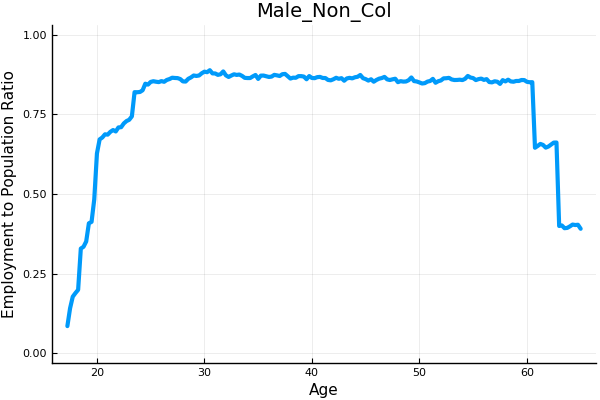

In [17]:
age = [(0.25* i+ 17) for i in collect(1:192) ]
employment_rate = []
for i = 1:P_nonc.J
    push!(employment_rate,mean(labor_sim_m_nonc[i,:])) #the employment_rate for the ith line
end

plot(age,employment_rate,label = "",lw = 3, ylims=[0,1], title = "Male_Non_Col",xlabel = "Age",ylabel= "Employment to Population Ratio")

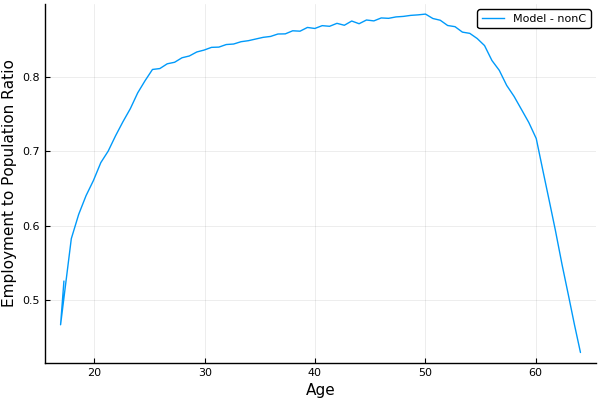

In [18]:
plot(Figure7_NonCol[1], Figure7_NonCol[2], 
    label="Model - nonC", xlabel = "Age", ylabel = "Employment to Population Ratio")

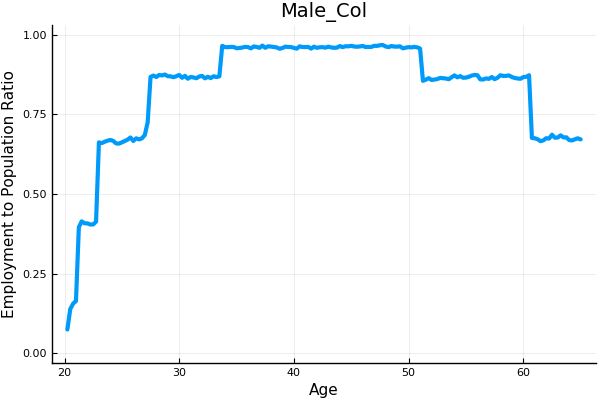

In [19]:
age = [(0.25* i+ 20) for i in collect(1:180) ]
employment_rate = []
for i = 1:P_c.J
    push!(employment_rate,mean(labor_sim_m_c[i,:])) #the employment_rate for the ith line
end

plot(age,employment_rate,label = "",lw = 3,ylims=[0,1],title = "Male_Col",xlabel = "Age",ylabel= "Employment to Population Ratio")

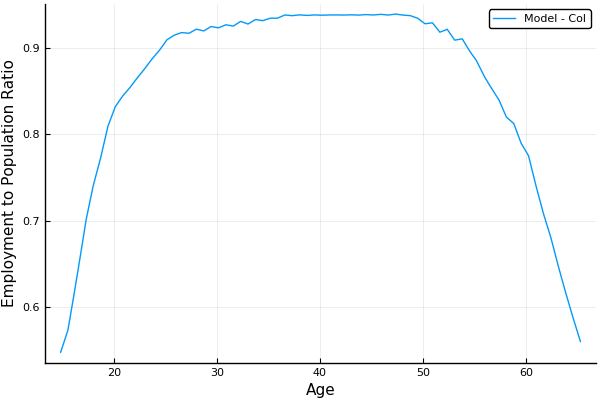

In [20]:
plot(Figure7_Col[1], Figure7_Col[2], 
    label="Model - Col", xlabel = "Age", ylabel = "Employment to Population Ratio")

### Figure 8

The simulation results for the wage of non-college males are shown in the graph below. The shapes of the curves look similar to the graph which is shown on page 178 in the paper. Nonetheless, each percentiles of the distribution of wages grows faster than the corresponding percentiles of wage presented in Fig.8.

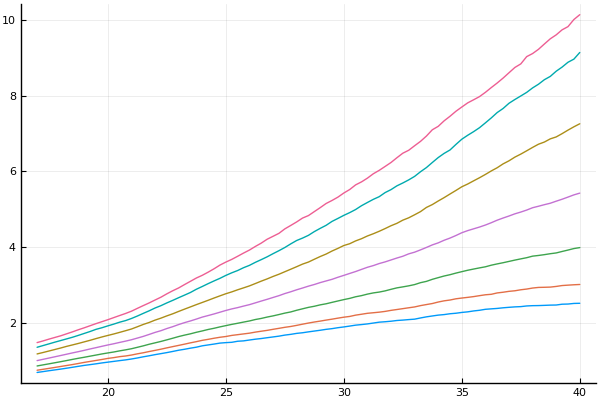

In [21]:
#non-college
quantile_needed = [0.05,0.1,0.25,0.5,0.75,0.9,0.95]
wage_percentage = SharedArray{Float64}(P_nonc.J, 7)

for (i,percentage) in enumerate(quantile_needed)
    for j in 1:P_nonc.J
        wage_percentage[j,i] = quantile(income_sim_m_nonc[j,:], percentage)
    end
end
median_first_stage = quantile(income_sim_m_nonc[1,:],0.5)  # median for the first period
standarded_wage = wage_percentage./median_first_stage
stop=(40-P_nonc.starting_age)*4+1
plot(P_nonc.starting_age:0.25:40,standarded_wage[1:stop,:], label = "")

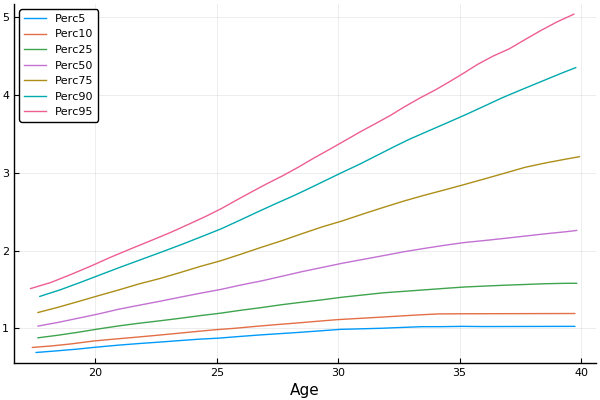

In [22]:
plot(Figure8_NonCol_Perc5[1], Figure8_NonCol_Perc5[2], 
    label="Perc5", xlabel = "Age")
plot!(Figure8_NonCol_Perc10[1], Figure8_NonCol_Perc10[2], label="Perc10")
plot!(Figure8_NonCol_Perc25[1], Figure8_NonCol_Perc25[2], label="Perc25")
plot!(Figure8_NonCol_Perc50[1], Figure8_NonCol_Perc50[2], label="Perc50")
plot!(Figure8_NonCol_Perc75[1], Figure8_NonCol_Perc75[2], label="Perc75")
plot!(Figure8_NonCol_Perc90[1], Figure8_NonCol_Perc90[2], label="Perc90")
plot!(Figure8_NonCol_Perc95[1], Figure8_NonCol_Perc95[2], label="Perc95")

### Figure 9

The simulation results of wage of college male differ from Fig.9 shown on page 179. All the curves become flat at their 30s. In the paper, the 75th, 90th and 95th percentiles of wage still saw significant growth after their mid-30s.

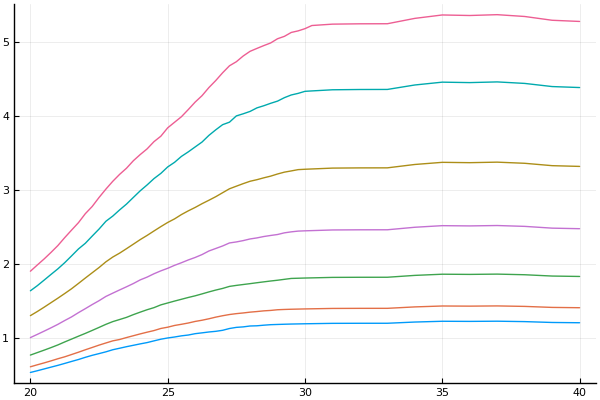

In [23]:
#college
quantile_needed = [0.05,0.1,0.25,0.5,0.75,0.9,0.95]
wage_percentage = SharedArray{Float64}(P_c.J, 7)

for (i,percentage) in enumerate(quantile_needed)
    for j in 1:P_c.J
        wage_percentage[j,i] = quantile(income_sim_m_c[j,:], percentage)
    end
end
median_first_stage = quantile(income_sim_m_c[1,:],0.5)  # median for the first period
standarded_wage = wage_percentage./median_first_stage
stop=(40-P_c.starting_age)*4+1
plot(P_c.starting_age:0.25:40,standarded_wage[1:stop,:], label = "")

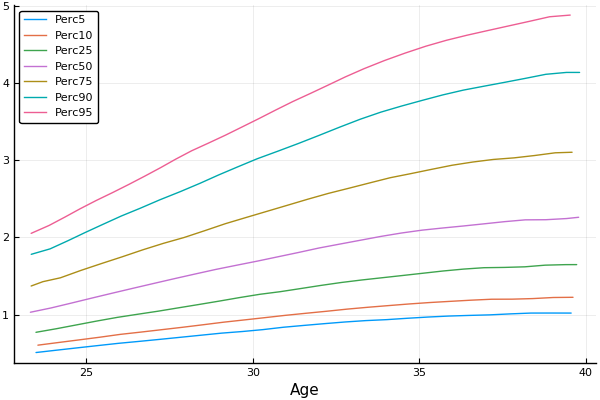

In [24]:
plot(Figure9_Col_Perc5[1], Figure9_Col_Perc5[2], label="Perc5", xlabel = "Age")
plot!(Figure9_Col_Perc10[1], Figure9_Col_Perc10[2], label="Perc10")
plot!(Figure9_Col_Perc25[1], Figure9_Col_Perc25[2], label="Perc25")
plot!(Figure9_Col_Perc50[1], Figure9_Col_Perc50[2], label="Perc50")
plot!(Figure9_Col_Perc75[1], Figure9_Col_Perc75[2], label="Perc75")
plot!(Figure9_Col_Perc90[1], Figure9_Col_Perc90[2], label="Perc90")
plot!(Figure9_Col_Perc95[1], Figure9_Col_Perc95[2], label="Perc95")

In [25]:
println(maximum(h_sim_m_nonc))
println(maximum(h_sim_m_c))

585.8016718295647
84.66694504602287


### Table 9

In [26]:
#non-college
period_40 = (40-P_nonc.starting_age)*4+1
unemployment_spell_end_m_nonc[period_40,:]=ones(length(unemployment_spell_end_m_nonc[period_40,:]))
total_spells=sum(unemployment_spell_end_m_nonc[1:period_40,:])
aux = unemployment_duration_m_nonc[1:period_40,:].*unemployment_spell_end_m_nonc[1:period_40,:]
criteria = ["x==1.0", "x==2.0","x==3.0","x==4.0","x>4.0"]
nonc9=zeros(length(criteria))
for (ind_c, c) in enumerate(criteria)
    myLine = Meta.parse("spell_1 = count(x->($(c)),aux) #counts numbers of spells of 1 quarter length")
    eval(myLine)
    nonc9[ind_c] =round(100*spell_1/total_spells; digits=1)
end

In [27]:
#college
period_40 = (40-P_c.starting_age)*4+1
unemployment_spell_end_m_c[period_40,:]=ones(length(unemployment_spell_end_m_c[period_40,:]))
total_spells=sum(unemployment_spell_end_m_c[1:period_40,:])
aux = unemployment_duration_m_c[1:period_40,:].*unemployment_spell_end_m_c[1:period_40,:]
criteria = ["x==1.0", "x==2.0","x==3.0","x==4.0","x>4.0"]
c9=zeros(length(criteria))
for (ind_c, c) in enumerate(criteria)
    myLine = Meta.parse("spell_1 = count(x->($(c)),aux) #counts numbers of spells of 1 quarter length")
    eval(myLine)
    c9[ind_c] =round(100*spell_1/total_spells; digits=1)
end
tab9 = [["" "Non-College" "College"]; ["1Q"; "2Q"; "3Q"; "4Q"; ">4Q"] nonc9 c9 ]

6×3 Array{Any,2}:
 ""       "Non-College"    "College"
 "1Q"   26.8             25.0       
 "2Q"   17.9             17.5       
 "3Q"   12.8             12.9       
 "4Q"    9.5              9.2       
 ">4Q"  27.5             28.3       

### Table 10

In [28]:
# College
period_40 = (40-P_c.starting_age)*4 + 4
fer_c_a = mean(sum(fertility_sim_f_c[1:period_40,:], dims=1))
fer_c_17_19 = 0
fer_c_20_24 = mean(sum(fertility_sim_f_c[1:20,:], dims=1))/fer_c_a*100
fer_c_25_29 = mean(sum(fertility_sim_f_c[21:40,:], dims=1))/fer_c_a*100
fer_c_30_34 = mean(sum(fertility_sim_f_c[41:60,:], dims=1))/fer_c_a*100
fer_c_35_40 = mean(sum(fertility_sim_f_c[61:84,:], dims=1))/fer_c_a*100

# Non_college
period_40 = (40-P_nonc.starting_age)*4 + 4
fer_nonc_a = mean(sum(fertility_sim_f_nonc[1:period_40,:], dims=1))
fer_nonc_17_19 = mean(sum(fertility_sim_f_nonc[1:12,:], dims=1))/fer_nonc_a*100
fer_nonc_20_24 = mean(sum(fertility_sim_f_nonc[13:32,:], dims=1))/fer_nonc_a*100
fer_nonc_25_29 = mean(sum(fertility_sim_f_nonc[33:52,:], dims=1))/fer_nonc_a*100
fer_nonc_30_34 = mean(sum(fertility_sim_f_nonc[53:72,:], dims=1))/fer_nonc_a*100
fer_nonc_35_40 = mean(sum(fertility_sim_f_nonc[73:96,:], dims=1))/fer_nonc_a*100

df_10 = DataFrame(Item = ["Average fertility","17-19","20-24","25-29","30-34","35-40"], Non_college = round.([fer_nonc_a,fer_nonc_17_19,fer_nonc_20_24,fer_nonc_25_29,fer_nonc_30_34,fer_nonc_35_40],digits=2), College=round.([fer_c_a,fer_c_17_19,fer_c_20_24,fer_c_25_29,fer_c_30_34,fer_c_35_40],digits=2))

UndefVarError: UndefVarError: DataFrame not defined

### Table 11

In [29]:
group = ["f_c","f_nonc","f_nonc_black"]
tab_11_sim = Array{Any}(undef,6,length(group))
for (ind_g, g) in enumerate(group)
    criteria = ["==0.25)","==0.5)", "==0.75)","==1.0)","<1.0).*(youngest_child_age_$(g).<=5.0)","<5.0).*(youngest_child_age_$(g).<=6.0)"]
    for (ind_i, i) in enumerate(criteria)
        MyLine1 = Meta.parse("binary = 1 .*(youngest_child_age_$(g) .$(i)") #assigns 1 to mothers with youngest child of age of desired criteria
        MyLine2 = Meta.parse("labor_bin = labor_sim_$(g).*binary") #assigns 1 to mothers that work and fulfill the prior criterium of youngest child age
        #println(MyLine1)
        eval(MyLine1)
        #println(MyLine2)
        eval(MyLine2)
        #println(sum(binary))
        tab_11_sim[ind_i, ind_g] = round(100*sum(labor_bin)/sum(binary); digits=1) #if NaN, mostly because binary=0
    end
end
tab_11_sim_described = ["College" "Non-College" "Black" ;tab_11_sim]
lengths = [" "; "1Q"; "2Q"; "3Q"; "4Q"; "1y-5y"; "5y-6y"]
tab_11_sim_described = [lengths tab_11_sim_described]

7×4 Array{Any,2}:
 " "        "College"    "Non-College"    "Black"
 "1Q"      7.9          6.2              5.7     
 "2Q"     36.5         27.4             27.1     
 "3Q"     41.1         30.0             30.2     
 "4Q"     49.2         36.5             34.0     
 "1y-5y"  82.8         77.0             77.0     
 "5y-6y"  82.6         76.7             76.6     

### Table 12

In [30]:
#non-college
period_40 = (40-P_nonc.starting_age)*4+1
unemployment_spell_end_f_nonc[period_40,:]=ones(length(unemployment_spell_end_f_nonc[period_40,:]))
total_spells=sum(unemployment_spell_end_f_nonc[1:period_40,:].*(child_sim_f_nonc[1:period_40,:].>0))
aux = unemployment_duration_f_nonc[1:period_40,:].*unemployment_spell_end_f_nonc[1:period_40,:].*(child_sim_f_nonc[1:period_40,:].>0)
criteria = ["x==1.0", "x==2.0","x==3.0","x==4.0","x>4.0"]
nonc13=zeros(length(criteria))
for (ind_c, c) in enumerate(criteria)
    myLine = Meta.parse("spell_1 = count(x->($(c)),aux) #counts numbers of spells of 1 quarter length")
    eval(myLine)
    nonc13[ind_c] =round(100*spell_1/total_spells; digits=1)
end

In [31]:
#college
period_40 = (40-P_c.starting_age)*4+1
unemployment_spell_end_f_c[period_40,:]=ones(length(unemployment_spell_end_f_c[period_40,:]))
total_spells=sum(unemployment_spell_end_f_c[1:period_40,:].*(child_sim_f_c[1:period_40,:].>0))
aux = unemployment_duration_f_c[1:period_40,:].*unemployment_spell_end_f_c[1:period_40,:].*(child_sim_f_c[1:period_40,:].>0)
criteria = ["x==1.0", "x==2.0","x==3.0","x==4.0","x>4.0"]
c13=zeros(length(criteria))
for (ind_c, c) in enumerate(criteria)
    myLine = Meta.parse("spell_1 = count(x->($(c)),aux) #counts numbers of spells of 1 quarter length")
    eval(myLine)
    c13[ind_c] =round(100*spell_1/total_spells; digits=1)
end
tab12 = [["" "Non-College" "College"]; ["1Q"; "2Q"; "3Q"; "4Q"; ">4Q"] nonc13 c13 ]

6×3 Array{Any,2}:
 ""       "Non-College"    "College"
 "1Q"   36.8             34.0       
 "2Q"   16.6             14.5       
 "3Q"    9.5              9.8       
 "4Q"    6.2              5.8       
 ">4Q"  19.5             19.4       

### Table 13

In [32]:
#non-college
period_40 = (40-P_nonc.starting_age)*4+1
unemployment_spell_end_f_nonc[period_40,:]=ones(length(unemployment_spell_end_f_nonc[period_40,:]))
total_spells=sum(unemployment_spell_end_f_nonc[1:period_40,:])
aux = unemployment_duration_f_nonc[1:period_40,:].*unemployment_spell_end_f_nonc[1:period_40,:]
criteria = ["x==1.0", "x==2.0","x==3.0","x==4.0","x>4.0"]
nonc13=zeros(length(criteria))
for (ind_c, c) in enumerate(criteria)
    myLine = Meta.parse("spell_1 = count(x->($(c)),aux) #counts numbers of spells of 1 quarter length")
    eval(myLine)
    nonc13[ind_c] =round(100*spell_1/total_spells; digits=1)
end

In [33]:
#college
period_40 = (40-P_c.starting_age)*4+1
unemployment_spell_end_f_c[period_40,:]=ones(length(unemployment_spell_end_f_c[period_40,:]))
total_spells=sum(unemployment_spell_end_f_c[1:period_40,:])
aux = unemployment_duration_f_c[1:period_40,:].*unemployment_spell_end_f_c[1:period_40,:]
criteria = ["x==1.0", "x==2.0","x==3.0","x==4.0","x>4.0"]
c13=zeros(length(criteria))
for (ind_c, c) in enumerate(criteria)
    myLine = Meta.parse("spell_1 = count(x->($(c)),aux) #counts numbers of spells of 1 quarter length")
    eval(myLine)
    c13[ind_c] =round(100*spell_1/total_spells; digits=1)
end
tab13 = [["" "Non-College" "College"]; ["1Q"; "2Q"; "3Q"; "4Q"; ">4Q"] nonc13 c13 ]

6×3 Array{Any,2}:
 ""       "Non-College"    "College"
 "1Q"   36.4             34.4       
 "2Q"   17.1             15.1       
 "3Q"   10.0              9.0       
 "4Q"    6.3              8.2       
 ">4Q"  19.8             18.9       

### Table 14

In [34]:
period_40 = (40-P_nonc.starting_age)*4+1
year_convert= 1
#non-College
e1_nonc = mean(sum(working_hours_sim_m_nonc[1:period_40,:]; dims=1))/year_convert #mean cumulative working hours up to age 40
e2_nonc = mean(sum(working_hours_sim_f_nonc[1:period_40,:]; dims=1))/year_convert
e3_nonc = e1_nonc/e2_nonc
#College
e1_c = mean(sum(working_hours_sim_m_c[1:period_40,:]; dims=1))/year_convert
e2_c = mean(sum(working_hours_sim_f_c[1:period_40,:]; dims=1))/year_convert
e3_c = e1_c/e2_c
tab = [e1_nonc e1_c;
        e2_nonc e2_c;
        e3_nonc e3_c]
disp = ["non-College" "College"; tab]
dips = [["";"Males";"Females";"Males/Females"] disp ]

4×3 Array{Any,2}:
 ""                   "non-College"      "College"
 "Males"          3230.16            3418.25      
 "Females"        2805.06            3045.2       
 "Males/Females"     1.15155            1.1225    

### Table 15

In [35]:
using DataFrames
group = ["c", "nonc"]
sexes = ["m", "f"]
for g in group
    for s in sexes
        Line1 = Meta.parse("income_40 = income_sim_$(s)_$(g)[4*(40 - P_$(g).starting_age)+1,:]")
        eval(Line1)
        if g == "c" 
            Line2 = Meta.parse("income_starting = income_sim_$(s)_$(g)[13,:]") # from age 23
        else 
            Line2 = Meta.parse("income_starting = income_sim_$(s)_$(g)[1,:]") # from age 17
        end
        eval(Line2)
        Line3 = Meta.parse("$(s)_$(g) = income_40./income_starting")
        eval(Line3)
        Line4 = Meta.parse("$(s)_$(g)_a = mean($(s)_$(g))")
        eval(Line4)
        Line5 = Meta.parse("$(s)_$(g)_t = mean($(s)_$(g)[$(s)_$(g).>median($(s)_$(g))])")
        eval(Line5)
        Line6 = Meta.parse("$(s)_$(g)_b = mean($(s)_$(g)[$(s)_$(g).<median($(s)_$(g))])")
        eval(Line6)
    end
end
df_15 = DataFrame(Wage_growth = ["Average","Top 50%","Bottom 50%"], m_nonc = round.([m_nonc_a,m_nonc_t,m_nonc_b],digits=2), f_nonc = round.([f_nonc_a,f_nonc_t,f_nonc_b], digits=2), m_c=round.([m_c_a,m_c_t,m_c_b],digits=2), f_c=round.([f_c_a,f_c_t,f_c_b],digits=2))

,Wage_growth,m_nonc,f_nonc,m_c,f_c
,String,Float64,Float64,Float64,Float64
1,Average,5.49,4.99,1.58,1.55
2,Top 50%,6.66,6.14,1.82,1.77
3,Bottom 50%,4.34,3.86,1.36,1.32


### Table 16

In [36]:
# before running table 16, you should run table 15
# College
income_nonchild_c = income_sim_f_c[:, child_sim_f_c[4*(40-P_c.starting_age)+1,:].==0]
f_nonchild_c = income_nonchild_c[4*(40-P_c.starting_age)+1, :]./income_nonchild_c[13, :]

wage_gap_c = (mean(m_c) - mean(f_c))/mean(m_c)
wage_gap_c_h = (mean(m_c) - mean(f_nonchild_c))/mean(m_c)
wage_gap_c_child = wage_gap_c - wage_gap_c_h
rate_c = round(wage_gap_c_child/wage_gap_c*100, digits=2)

# Non_college
income_nonchild_nonc = income_sim_f_nonc[:, child_sim_f_nonc[4*(40-P_nonc.starting_age)+1,:].==0]
f_nonchild_nonc = income_nonchild_nonc[4*(40-P_nonc.starting_age)+1, :]./income_nonchild_nonc[1, :]

wage_gap_nonc = (mean(m_nonc) - mean(f_nonc))/mean(m_nonc)
wage_gap_nonc_h = (mean(m_nonc) - mean(f_nonchild_nonc))/mean(m_nonc)
wage_gap_nonc_child = wage_gap_nonc - wage_gap_nonc_h
rate_nonc = round(wage_gap_nonc_child/wage_gap_nonc*100, digits=2)

df_16 = DataFrame(Economy = ["Benchmark","Only children","Only hours"], Non_college = round.([wage_gap_nonc,wage_gap_nonc_child,wage_gap_nonc_h],digits=2), Rate_nonc=[rate_nonc,rate_nonc,rate_nonc], College=round.([wage_gap_c,wage_gap_c_child,wage_gap_c_h],digits=2), Rate_c =[rate_c,rate_c,rate_c])

,Economy,Non_college,Rate_nonc,College,Rate_c
,String,Float64,Float64,Float64,Float64
1,Benchmark,0.09,3.16,0.02,-68.96
2,Only children,0.0,3.16,-0.02,-68.96
3,Only hours,0.09,3.16,0.04,-68.96


### Table 17

In [37]:
f_nonc_black_a = mean(income_sim_f_nonc_black[4*(40-P_nonc_black.starting_age)+1,:]./income_sim_f_nonc_black[1,:])
black_ratio = f_nonc_black_a/f_nonc_a
df_17 = DataFrame(Item = ["Black non-college", "All non-college", "Ration"], Model = round.([f_nonc_black_a, f_nonc_a, black_ratio], digits=2))

,Item,Model
,String,Float64
1,Black non-college,5.02
2,All non-college,4.99
3,Ration,1.01


## Sources

Erosa, A. et al. (2015). A quantitative theory of the gender gap in wages. European Economic Review, 85, 165–187.

Fernandez, J. & Valencia, D. (2018). A Practical Guide toParallelization in Economics. Retrieved 21 June 2019 from https://www.sas.upenn.edu/~jesusfv/Guide_Parallel.pdf

Rohatgi, A. (2019). WebPlotDigitizer. Retrieved 16 June 2016 from https://automeris.io/WebPlotDigitizer